This is Strat 2:  [[0.00404858 0.01214575 0.00850202 0.00404858 0.02834008]
 [0.00404858 0.01214575 0.01214575 0.00404858 0.03643725]
 [0.00404858 0.01214575 0.03643725 0.00404858 0.01214575]
 [0.01214575 0.02834008 0.01214575 0.02834008 0.01214575]
 [0.00404858 0.03643725 0.02834008 0.00404858 0.03643725]]
This is Strat 2:  [[0.00420168 0.01260504 0.00882353 0.00420168 0.02941176]
 [0.00420168 0.01260504 0.01260504 0.00420168 0.03781513]
 [0.00420168 0.01260504 0.00378151 0.00420168 0.01260504]
 [0.01260504 0.02941176 0.01260504 0.02941176 0.01260504]
 [0.00420168 0.03781513 0.02941176 0.00420168 0.03781513]]
This is Strat 2:  [[0.00436681 0.01310044 0.00917031 0.00436681 0.03056769]
 [0.00436681 0.01310044 0.01310044 0.00436681 0.03930131]
 [0.00436681 0.01310044 0.00393013 0.00436681 0.01310044]
 [0.01310044 0.03056769 0.01310044 0.03056769 0.01310044]
 [0.00436681 0.00393013 0.03056769 0.00436681 0.03930131]]
This is Strat 2:  [[0.00454545 0.01363636 0.00954545 0.00454545 0.0318181

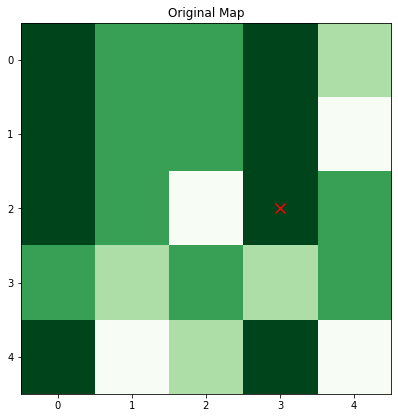

In [9]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from matplotlib import cm
import random
import matplotlib.gridspec as gridspec
import sys
import copy
import time


dim = 5

flatTerrainRate = 0.1
hillyTerrainRate = 0.3
forestedTerrainRate = 0.7
caveTerrainRate = 0.9

flat = 0 
hilly = 1
forested = 2
cave = 3

# Generates the terrain and values for the map
def generateMap(dim):
        map = np.zeros([dim, dim])
        for i in range(dim):
            for j in range(dim):
                p = np.random.rand()
                if p <= 0.2:
                    # Initialize Flat Terrain
                    map[i][j] = flat
                elif p > 0.2 and p <= 0.5:
                    # Initialize Hilly Terrain
                    map[i][j] = hilly
                elif p > 0.5 and p <= 0.8:
                    # Initialize Forested Terrain
                    map[i][j] = forested
                else:
                    # Initialize Cave Terrain
                    map[i][j] = cave
        return map

# Generates the coordinates of the target marker and agent marker
def generateMarker(dim):
    i = np.random.randint(dim)
    j = np.random.randint(dim)
    return [i, j]

# Generates the initial probability state of the grid 
def generateInitialState(dim):
    initialProb = 1/(dim*dim)
    probState = np.zeros([dim, dim])
    for i in range(dim):
        for j in range(dim):
            probState[i][j] = initialProb
    return probState

# Generates the initial grid for part 2
def generateStratTwoState(dim):
    initialProb = 1/(dim*dim)
    probState = np.zeros([dim, dim])
    for i in range(dim):
        for j in range(dim):
            probState[i][j] = initialProb
    return probState

# State where agent is at target coordinate and tries to find the target
def targetState(t, map, agent, target):
    foundVal = np.random.rand()
    targeti = agent[0]
    targetj = agent[1]

    # If the randomly generated number is greater than the rate of the target then the target is found
    if map[targeti][targetj] == flat :
        if foundVal > flatTerrainRate :
            print(t)
            return 1
    elif map[targeti][targetj] == hilly :
       if foundVal > hillyTerrainRate :
            print(t)
            return 1
    elif map[targeti][targetj] == forested :
       if foundVal > forestedTerrainRate :
            print(t)
            return 1
    else :
        if foundVal > caveTerrainRate :
            print(t)
            return 1
    
    # if not found we continue with update
    return
        

# Updates our current belief state at time t
def updateBeliefState(dim, beliefState, t, map, agent, target):
    agenti = agent[0]
    agentj = agent[1]
    if (agent[0] == target[0] and agent[1] == target[1]):
        check = targetState(t, map, agent, target)
        # if check successful return 1 and print chart
        if (check == 1) :
            validPrint = printGrid(map, target)
            if(validPrint == 1):
                return 0

    beliefState[agenti][agentj]
    if map[agenti][agentj] == flat :
        # currentProb = flatTerrainRate * initialProb
        #print("flats")
        beliefState[agenti][agentj] = beliefState[agenti][agentj] * flatTerrainRate
    elif map[agenti][agentj] == hilly :
        # currentProb = hillyTerrainRate * initialProb
        #print("hilly")
        beliefState[agenti][agentj] = beliefState[agenti][agentj] * hillyTerrainRate
    elif map[agenti][agentj] == forested :
        # currentProb = forestedTerrainRate * initialProb
        #print("forested")
        beliefState[agenti][agentj] = beliefState[agenti][agentj] * forestedTerrainRate
    else :
        # currentProb = caveTerrainRate * initialProb
        #print("cave")
        beliefState[agenti][agentj] = beliefState[agenti][agentj] * caveTerrainRate
    
    newTotal = np.sum(beliefState)

    #newProbOfCurr = currentProb / newTotal
    #newProbOfRest = initialProb / newTotal

    #beliefState[0:dim][0:dim] = newProbOfRest
    #beliefState[x][y] = newProbOfCurr
    beliefState = beliefState/newTotal
    #print("inside", beliefState)
    return beliefState
   

# returns manhattan distance between two coordinates
def manhattanDistance(x1, y1, x2, y2):
        return abs(x1-x2) + abs(y1-y2)

# Searches grid for next position that agent shall search
def searchNext(t, dim, beliefState, agent):
    maxVal = 0
    mXCoor = 0
    mYCoor = 0
    smallestDist = dim * dim
    for searchi in range(dim):
        for searchj in range(dim):
            if beliefState[searchi][searchj] > maxVal:
                maxVal = beliefState[searchi][searchj]
                mXCoor = searchi
                mYCoor = searchj
                smallestDist = dim * dim
            elif beliefState[searchi][searchj] == maxVal:
                manDist = manhattanDistance(searchi, searchj, agent[0], agent[1])
                if manDist < smallestDist:
                    smallestDist = manDist
                    maxVal = beliefState[searchi][searchj]
                    mXCoor = searchi
                    mYCoor = searchj
    agent[0] = mXCoor
    agent[1] = mYCoor

def updateStrategyTwo(dim, beliefState, stratTwoState, map):
    terrainRate = 0
    for i in range(dim):
        for j in range(dim):
            if map[i][j] == flat :
                terrainRate = flatTerrainRate
            elif map[i][j] == hilly :
                terrainRate = hillyTerrainRate
            elif map[i][j] == forested :
                terrainRate = forestedTerrainRate
            else :
                terrainRate = caveTerrainRate
            stratTwoState[i][j] = (1 - terrainRate) * beliefState[i][j]
        
    return stratTwoState

# Runs the search for the agent
def executeRule2():
    t = 0
    map = generateMap(dim)
    target = generateMarker(dim)
    agent = generateMarker(dim)
    beliefState = generateInitialState(dim) 
    stratTwoState = generateStratTwoState(dim)
    while True:
        t = t + 1
        beliefState = updateBeliefState(dim, beliefState, t, map, agent, target)
        if isinstance(beliefState,int):
            return
        stratTwoState = updateStrategyTwo(dim, beliefState, stratTwoState, map)
        # print("outside", beliefState)
        # print("This is Strat 2: ", stratTwoState)
        searchNext(t,dim,stratTwoState,agent)
    return
def printGrid(map, target):
    grid = gridspec.GridSpec(ncols=2, nrows=2)
    # Make a grid of 4 equal parts
    fig = plt.figure(figsize=(15,15))
    ogMap = fig.add_subplot(grid[0, 0])
    Image = ogMap.imshow(map, cmap = cm.get_cmap('Greens', 4))
    ogMap.set_title("Original Map")
    ogMap.scatter(target[1], target[0], s=100, c='red', marker='x')
    return 1

executeRule2()

